In [1]:
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST, imread
from functools import cmp_to_key
import numpy as np
import matplotlib.pyplot as plt
from time import time
import cv2
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace
from numpy import unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32

# SIFT

## Step 1: Building DoG Octaves

In [2]:
def computeNumberOfOctaves(image_shape):
    """Defines the number of octaves to compute"""
    return int(np.log(min(image_shape))/np.log(2) -1)

def generateBaseImage(image, sigma, assumed_blur):
    """Sets the blur of the first image to a value of sigma"""

    # Multiply the size of the image by two
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)

    # set a value of initial blur
    sig = np.sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))

    # set initial blur to sigma
    return GaussianBlur(image, (0, 0), sigmaX=sig, sigmaY=sig)

def generateGaussianKernels(sigma, num_sets):
    """Computes the blur scale with the initial blur being sigma"""

    # Initializing the blur_scale by sigma
    num_img = num_sets + 3 #we loose one image with the DoG and the 1st and last don't count
    k = 2**(1/num_sets)
    blur_scale = np.zeros(num_img)
    blur_scale[0] = sigma

    # multiplying the blur by 2**(1/s) to achieve twice the blur
    for i in range(1, num_img):
        sigma_previous = k**(i-1) * sigma
        sigma_after = k * sigma_previous
        blur_scale[i] = np.sqrt(sigma_after**2 - sigma_previous**2)

    return blur_scale

def generateGaussianImages(image, num_octaves, blur_scale):
    """Defines the gaussian octaves that will be used to build the DoG octaves"""
    octaves = []

    # Computing num_octaves, each with num_sets images
    for i in range(num_octaves):
        octave =  []
        octave.append(image)

        for blur in blur_scale[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=blur, sigmaY=blur)
            octave.append(image)
        octaves.append(octave)

        # Resizing the image (division by 2) to use it as base for next octave
        new_base = octave[-3]
        image = resize(new_base, (int(new_base.shape[1] / 2), int(new_base.shape[0] / 2)), interpolation=INTER_NEAREST)

    return np.array(octaves, dtype=object)

def generateDoGImages(gaussian_octaves):
    """Computes the DoG octaves by taking the difference of two consecutive
    images from the gaussian octaves"""

    dog_octaves = []

    for octave in gaussian_octaves:
        dog_oct = []
        for i in range(1,len(octave)):
            dog_oct.append(subtract(octave[i], octave[i-1]))
        dog_octaves.append(dog_oct)

    return np.array(dog_octaves, dtype=object)

## Step 2 Keypoint Localization

In [3]:
def grad_and_hessian(im):
    """Computes the gradient and the Hessian of a given cube of pixels of size 3x3x3"""

    #computing the gradient
    dx = (im[1, 1, 2] - im[1, 1, 0])/2
    dy = (im[1, 2, 1] - im[1, 0, 1])/2
    ds = (im[2, 1, 1] - im[0, 1, 1])/2

    grad =  np.array([dx, dy, ds])

    #computing the Hessian
    cpixel = im[1, 1, 1]
    dxx = im[1, 1, 2] - 2 * cpixel + im[1, 1, 0]
    dyy = im[1, 2, 1] - 2 * cpixel + im[1, 0, 1]
    dss = im[2, 1, 1] - 2 * cpixel + im[0, 1, 1]
    dxy = (im[1, 2, 2] - im[1, 2, 0] - im[1, 0, 2] + im[1, 0, 0])/4
    dxs = (im[2, 1, 2] - im[2, 1, 0] - im[0, 1, 2] + im[0, 1, 0])/4
    dys = (im[2, 2, 1] - im[2, 0, 1] - im[0, 2, 1] + im[0, 0, 1])/4

    hess =  np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

    return grad, hess

def is_extremum(im1, im2, im3, thresh):
    """For a given cube of pixels of size 3x3x3, returns True if the center pixel is
    an extremum, False otherwise"""

    # checks if the middle pixel is an extremum
    n, p = im1.shape
    new_sub_im = np.zeros((n,p,3))
    new_sub_im[:,:,0] = im1
    new_sub_im[:,:,1] = im2
    new_sub_im[:,:,2] = im3
    # take the pixel in the middle of the 3x3x3 subimage
    interest_pixel = im2[1,1]

    if abs(interest_pixel) > thresh:
        if interest_pixel == np.amax(new_sub_im):
            return True
        elif interest_pixel == np.amin(new_sub_im):
            return True
    return False

def outside_image(i, j, width, image_shape0, image_shape1, img_ind, num_sets):
    """For a given pixel at place i, j, returns True if pixel is outside of the considered
    frame of the image, False otherwise"""

    if i < width or i >= image_shape0 - width or j < width or j >= image_shape1 - width or img_ind < 1 or img_ind > num_sets:
            return True
    return False

def localize_extremum(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Checks the two conditions given by the SIFT paper. Gets rid of points such that:
        - the intensity of the extrema is under a certain threshold (low contrast)
        - Edge responses"""

    extremum_is_outside_image = False

    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient, hessian = grad_and_hessian(pixel_cube)

        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if outside_image:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

## Step 3: Orientation Assignment

In [4]:
def compute_orientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [5]:
def all_keypoints(gaussian_octaves, dog_octaves, num_sets, sigma, width, thresh=0.04):


    threshold = np.floor(0.5 * thresh / num_sets * 255) #from opencv implementation
    all_keypoints = []

    for oct_ind, dog_oct in enumerate(dog_octaves):
        for img_ind, (im1, im2, im3) in enumerate(zip(dog_oct, dog_oct[1:], dog_oct[2:])):
            n , p = im1.shape[0], im1.shape[1]
            for i in range(width, n-width):
                for j in range(width, p-width):
                    if is_extremum(im1[i-1:i+2, j-1:j+2], im2[i-1:i+2, j-1:j+2], im3[i-1:i+2, j-1:j+2], threshold):
                        loc = localize_extremum(i, j, img_ind + 1, oct_ind, num_sets, dog_oct, sigma, thresh, width)
                        if loc is not None:
                            keypoint, localization = loc
                            keypoints_oriented = compute_orientations(keypoint, oct_ind, gaussian_octaves[oct_ind][localization])

                            for kp in keypoints_oriented:
                                all_keypoints.append(kp)
    return all_keypoints

## Step 4: Local Descriptor Creation

In [6]:
def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints


def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints


def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

## SIFT: End to End

### Original images

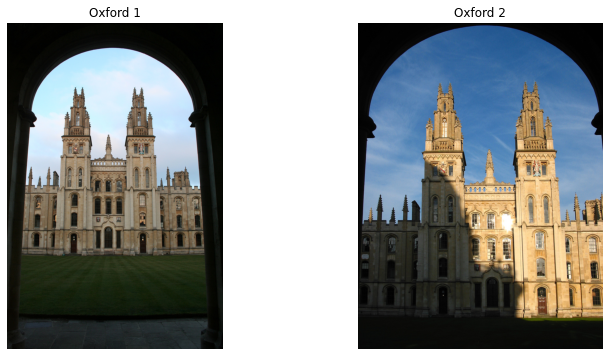

In [7]:
img1 = plt.imread('all_souls_000002.jpg')
img2 = plt.imread('all_souls_000015.jpg')

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Oxford 1')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Oxford 2')

plt.show()

### Keypoints and Descriptors

In [8]:
float_tolerance = 1e-7

def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image
    """
    image = image.astype('float32')
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = all_keypoints(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

In [9]:
top = time()

img_path_1 = 'all_souls_000002.jpg'
img_path_2 = 'all_souls_000015.jpg'

img1 = cv2.imread(img_path_1, 0)
keypoints1, descriptors1 = computeKeypointsAndDescriptors(img1, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5)

img2 = cv2.imread(img_path_2, 0)
keypoints2, descriptors2 = computeKeypointsAndDescriptors(img2, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5)

print('Temps d\'exécution', time() - top)

Temps d'exécution 485.4388794898987


# Plotting the Keypoints

In [10]:
def plotting_keypoints(keyp, img, title):
    x_list = []
    y_list = []
    for kp in keyp:
        kx, ky = kp.pt[0], kp.pt[1]
        x_list.append(kx)
        y_list.append(ky)
    plt.imshow(img)
    plt.title('Keypoints computed by original SIFT')
    plt.axis('off')
    plt.plot(x_list,y_list, 'o')
    plt.savefig(title)
    plt.show()

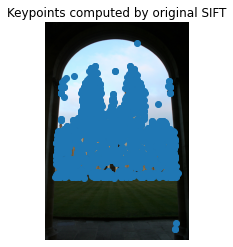

In [11]:
plotting_keypoints(keypoints1, plt.imread('all_souls_000002.jpg'),'Images/Keypoints1_original_SIFT.png')

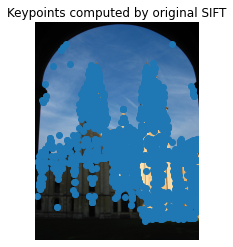

In [12]:
plotting_keypoints(keypoints2, plt.imread('all_souls_000015.jpg'), 'Images/Keypoints2_original_SIFT.png')

# Matching with Geometric Matching

In [13]:
def NN_im1_im2(frames1, descrs1, descrs2):
    N_frames1 = frames1.shape[0]
    matches=np.zeros((N_frames1,2),dtype=np.int)
    matches[:,0]=range(N_frames1)
    descrs1=descrs1.astype(np.float64)
    descrs2=descrs2.astype(np.float64)
    for i in range(N_frames1):
        mat = np.argmin(np.sqrt(np.sum((descrs2-descrs1[i])**2,axis=1)))
        matches[i,1]=mat
    return matches

def ransac(frames1,frames2,matches,N_iters=10000,dist_thresh=35):
    # initialize
    max_inliers=0
    tnf=None
    # run random sampling
    for it in range(N_iters):
        # pick a random sample
        i = np.random.randint(0,frames1.shape[0])
        x_1,y_1,s_1,theta_1=frames1[i,:]
        j = matches[i,1]
        x_2,y_2,s_2,theta_2=frames2[j,:]

        # estimate transformation
        theta = (theta_1-theta_2)
        s = s_2/s_1
        t_x = x_2 - s*(x_1*np.cos(theta)-y_1*np.sin(theta))
        t_y = y_2 - s*(x_1*np.sin(theta)+y_1*np.cos(theta))

        # evaluate estimated transformation
        X_1 = frames1[:,0]
        Y_1 = frames1[:,1]
        X_2 = frames2[matches[:,1],0]
        Y_2 = frames2[matches[:,1],1]

        X_1_prime = s*(X_1*np.cos(theta)-Y_1*np.sin(theta))+t_x
        Y_1_prime = s*(X_1*np.sin(theta)+Y_1*np.cos(theta))+t_y
      
        dist = np.sqrt((X_1_prime-X_2)**2+(Y_1_prime-Y_2)**2)
        inliers_indices = np.flatnonzero(dist<dist_thresh)
        num_of_inliers = len(inliers_indices)

        # keep if best
        if num_of_inliers>max_inliers:
            max_inliers=num_of_inliers
            best_inliers_indices = inliers_indices
            tnf = [t_x,t_y,s,theta]

    return (tnf,best_inliers_indices)

def keypoints_to_frames(keypoints):
    frames = np.zeros((len(keypoints),4))
    for i, keyp in enumerate(keypoints):
        # print(keyp.pt)
        frames[i,0], frames[i,1] = keyp.pt[0], keyp.pt[1]
        frames[i,2] = keyp.size
        frames[i,3] = keyp.angle
    return frames

def plot_geom(filtered_matches, im1, im2, frames1, frames2):
    plt.figure()
    plt.imshow(np.concatenate((im1,im2),axis=1))
    for idx in range(filtered_matches.shape[0]):
        i=filtered_matches[idx,0]
        j=filtered_matches[idx,1]
        plt.gca().scatter([frames1[i,0],im1.shape[1]+frames2[j,0]], [frames1[i,1],frames2[j,1]], s=5, c='green')
        plt.plot([frames1[i,0],im1.shape[1]+frames2[j,0]],[frames1[i,1],frames2[j,1]],linewidth=0.5)
    plt.axis('off')
    plt.savefig('Images/original_SIFT_GM.png')
    plt.show()

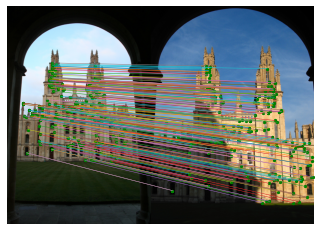

In [14]:
# loading images
img_1 = plt.imread(img_path_1)
img_2 = plt.imread(img_path_2)

frames1 = keypoints_to_frames(keypoints1)
frames2 = keypoints_to_frames(keypoints2)

# matches
matches = NN_im1_im2(frames1, descriptors1, descriptors2)

# filtered matches
_,inliers_indices=ransac(frames1,frames2,matches)
filtered_matches = matches[inliers_indices,:]

# plot
plot_geom(filtered_matches, img_1, img_2, frames1, frames2)